# **Model for the prediction of geminivirus given nucleotide sequences**

This model is built based on the two distints nonanucleotides found within the entire members of the family ***geminviridae***. These nonanuclotides (**"TAATATTAC** and **TAAGATTCC"**) promote the virus replication. Thus, they are upheld to predict geminivirus from the high throughput sequencing. This simple model make use of convolutional neural network to scan the nonanucleotide motifs.

In [60]:
# Import the required libraries

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import keras
from Bio import SeqIO, Seq
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dropout, Activation, Dense, Layer, Flatten, Input, MaxPooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import RandomOverSampler as ROS
import warnings
warnings.filterwarnings('ignore')

# Generation of input data to build the predictive model
Biological sequences were generated by concatenating multiple genome of geminiviruses

#    1     **Exploratory data analysis**

In [62]:
with open('Merged_data.fas') as raw_seq:  # Open to reveal the data
    for file in SeqIO.parse(raw_seq, 'fasta'):  # iterate the data components
        print(file.id)
        print(repr(file.seq))
        print(len(file))

data
Seq('TAATATTACCGGATGGCCGTTTTTTCTTTAGGCGGCCAATGAGAAGGAGACACG...ATT')
157633


In [63]:
file2 = SeqIO.read('Merged_data.fas', 'fasta')  # Load the sequences
file = file2.seq

split_data = [file[x:x+100] for x in range(0, len(file), 100)]  # Split the nucleotide sequences into 100 bases

data_frame = pd.DataFrame(split_data)  # Fit the every splitted sequences into table
data_frame.columns = ['Sequences']  # Naming the column containing the sequences "Sequence"

data_frame['Length'] = data_frame.iloc[:, :].astype(str).sum(axis=1).str.len()  # Column named "Length" is created for the number of sequence
data_frame

,Sequences,Length
0,"(T, A, A, T, A, T, T, A, C, C, G, G, A, T, G, ...",100
1,"(T, G, C, T, A, G, T, G, G, G, G, T, T, C, T, ...",100
2,"(C, C, T, G, C, G, G, A, G, T, T, A, C, T, G, ...",100
3,"(A, G, A, T, A, T, T, C, A, G, G, G, C, C, C, ...",100
4,"(G, C, C, C, A, T, A, T, T, A, C, A, G, G, C, ...",100
...,...,...
1572,"(C, T, G, A, A, T, G, T, T, C, G, G, A, T, G, ...",100
1573,"(T, G, G, A, G, A, T, G, A, G, G, C, A, C, C, ...",100
1574,"(C, T, T, T, T, G, T, T, A, A, T, G, A, G, C, ...",100
1575,"(G, A, C, A, C, T, C, A, A, A, A, C, T, C, C, ...",100


In [64]:
d_frame = data_frame[~(data_frame['Length'] != 100)]  # Remove the rows with less than 100 bases to maintain length unformity

d_frame.head()  # Display first five rows of the data

,Sequences,Length
0,"(T, A, A, T, A, T, T, A, C, C, G, G, A, T, G, ...",100
1,"(T, G, C, T, A, G, T, G, G, G, G, T, T, C, T, ...",100
2,"(C, C, T, G, C, G, G, A, G, T, T, A, C, T, G, ...",100
3,"(A, G, A, T, A, T, T, C, A, G, G, G, C, C, C, ...",100
4,"(G, C, C, C, A, T, A, T, T, A, C, A, G, G, C, ...",100


# Creating labels
### Add target to every 100 nucleotide sequences based on the prensence or absence of TAATATTAC or TAAGATTCC

In [66]:
#  Add target to each row of the sequences 

d_frame['Target'] = d_frame['Sequences'].astype(str).str.contains('TAATATTAC|TAAGATTCC', regex=True, case=False) # or TAATATTAC''
d_frame.head()   # Display first five rows of the data

,Sequences,Length,Target
0,"(T, A, A, T, A, T, T, A, C, C, G, G, A, T, G, ...",100,True
1,"(T, G, C, T, A, G, T, G, G, G, G, T, T, C, T, ...",100,False
2,"(C, C, T, G, C, G, G, A, G, T, T, A, C, T, G, ...",100,False
3,"(A, G, A, T, A, T, T, C, A, G, G, G, C, C, C, ...",100,False
4,"(G, C, C, C, A, T, A, T, T, A, C, A, G, G, C, ...",100,False


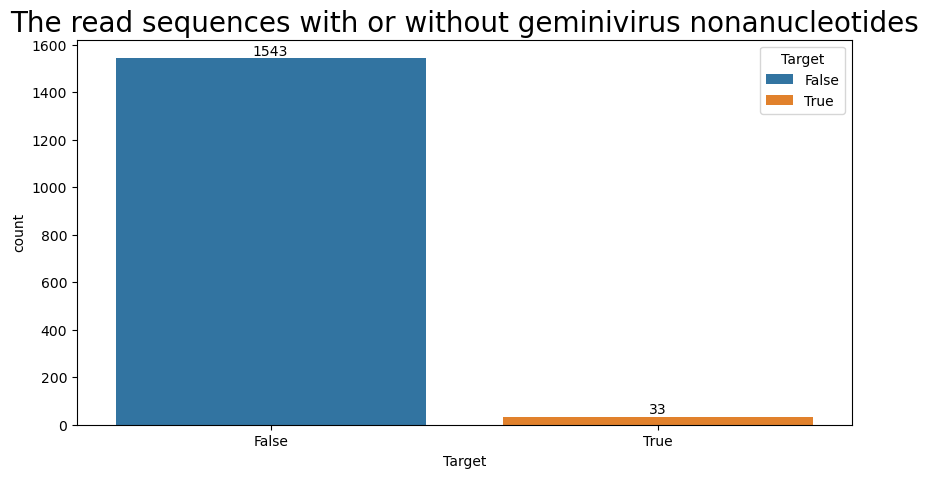

In [67]:
# Visualize the distibution of thr target variable

plt.figure(figsize = (10,5))
count= sb.countplot(data = d_frame, x = 'Target', hue = 'Target')  # Count the classes of the target variable
plt.title('The read sequences with or without geminivirus nonanucleotides', size = 20)  # Plot the frequency belongs to each classes
# function to label the count on the chart
for i in count.containers:
    count.bar_label(i)  # Put the data label on the bar

# Balance the frquency of the target variable in a random manner using Imblearn library

It helps to avoid some learning bias!
The classes (True or False) have and imbalance cases, this may create opportunity for the algorithm to learn wrong feature as a result of very low number of cases of one of the classes. Thus, affect the model accuracy. Below is the code to balance the two classes

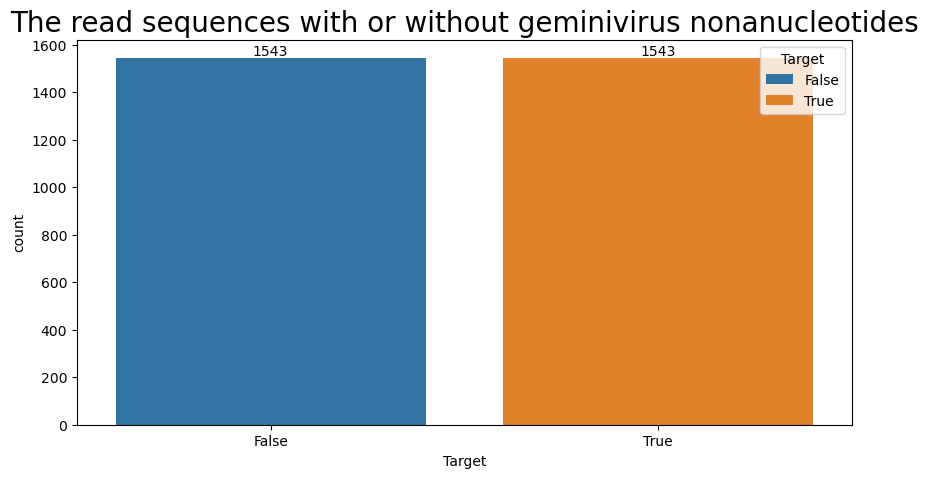

In [69]:
# Separate the dependent (target) and the independent variables

y = d_frame['Target']  # This is the target variable
inp_var = d_frame.drop('Target', axis=1)  # This are the independent variables
x = inp_var

# The target variable is column 'Target' with 2 imbalance classes (True or False) as visualized above
# The code section below explicitly details the over-sampling techniques using imblearn library
# This is necessary to avoid learning bias for the possible algorithms of the predictive modelling

ros = ROS(random_state=42)
x_ros, y_ros = ros.fit_resample(x, y)  # model the random sampling to balance counts

# Visualizing the target variable now to affirm if the two classes are balance now

balnc_dat = pd.concat([x_ros, y_ros], axis = 1)  # This code line join both datasets by column

plt.figure(figsize=(10, 5))
count = sb.countplot(data=balnc_dat, x = 'Target', hue  = 'Target')
plt.title('The read sequences with or without geminivirus nonanucleotides', size = 20)

# Loop function to label the count on the bar chart

for i in count.containers:  # This loops on the counted numbers, stored in the contatiners for each class
    count.bar_label(i)  # Uphold and display the counted numbers on the bar chart as a data label

# 2 **Feature Engineering**
Encoding the Target into 1 or 0. Additionally, One hot encoding for each of the nucleotide bases (A,C,G,T)

In [71]:

balnc_dat.replace({True: 1, False: 0}, inplace=True)  # Encoding the Target into 1 or 0
balnc_dat.head()  # Display first five rows of the data

,Sequences,Length,Target
0,"(T, A, A, T, A, T, T, A, C, C, G, G, A, T, G, ...",100,1
1,"(T, G, C, T, A, G, T, G, G, G, G, T, T, C, T, ...",100,0
2,"(C, C, T, G, C, G, G, A, G, T, T, A, C, T, G, ...",100,0
3,"(A, G, A, T, A, T, T, C, A, G, G, G, C, C, C, ...",100,0
4,"(G, C, C, C, A, T, A, T, T, A, C, A, G, G, C, ...",100,0


In [72]:

le = LabelEncoder()  # Containerize label encoder into a variable
he = OneHotEncoder()  # Containerize one hot encoder into a variable

seqMatrix = []  # Initialize list

for sequence in balnc_dat['Sequences']:  # Iterate sequence 
    leTrans = le.fit_transform(list(sequence))  # Transform it to ordinal form like 0,1,2,3
    leshape = np.array(leTrans).reshape(-1,1)  
    h_encode = he.fit_transform(leshape)  # TRansform the ordinal form to Zeros and 1 for nucleotide
    seqMatrix.append(h_encode.toarray())  # Convert it to an array then add to the initializes lists

sequence_matrix = np.stack(seqMatrix)  # Arrange the array over one  another
print(sequence_matrix.shape)

(3086, 100, 4)


# 3 **Build the predictive model**

Convolutional neural network is used for the prediction

In [74]:
#  Split data for training and testing
X_train, X_test, Y_train, Y_test = train_test_split(sequence_matrix, y_ros, test_size = 0.25)
print(X_train.shape)
print(Y_train.shape)

(2314, 100, 4)
(2314,)


In [75]:
# Selected parameters for the predictive model
mod = Sequential()
mod.add(Conv1D(filters=32, kernel_size =12, input_shape = (100, 4)))
mod.add(MaxPooling1D(pool_size= 4)),
mod.add(Flatten())
mod.add(Dropout(0.02))
mod.add(Dense(16, activation = 'relu'))
mod.add(Dense(1, activation = 'sigmoid'))
mod.compile(loss= 'binary_crossentropy', optimizer = 'adam', metrics = ['binary_accuracy'])
mod.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 89, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 22, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │        11,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,865 (50.25 KB)

 Trainable params: 12,865 (50.25 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 20)
pointer_check = ModelCheckpoint(filepath = 'checkpoint.keras', monitor='val_loss', save_best_only = True)

#  Training the model
hist = mod.fit(X_train, Y_train, batch_size = 200, epochs=5, verbose =1, validation_split = 0.1, callbacks = [stop_early, pointer_check])
hist.history

print(np.mean(hist.history['binary_accuracy']))  # Print the trained model accuracy
print(np.mean(hist.history['loss']))  # Print the Trained model loss function

Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - binary_accuracy: 0.5867 - loss: 0.6755 - val_binary_accuracy: 0.8922 - val_loss: 0.5628
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - binary_accuracy: 0.9016 - loss: 0.5390 - val_binary_accuracy: 0.9310 - val_loss: 0.4185
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - binary_accuracy: 0.9451 - loss: 0.3949 - val_binary_accuracy: 0.9698 - val_loss: 0.2814
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - binary_accuracy: 0.9514 - loss: 0.2705 - val_binary_accuracy: 0.9741 - val_loss: 0.1866
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - binary_accuracy: 0.9684 - loss: 0.1852 - val_binary_accuracy: 0.9828 - val_loss: 0.1274
0.8844380378723145
0.3933307319879532


In [77]:

evaluate = mod.evaluate(X_test, Y_test, batch_size = 32)  # Evaluate the model

print('test loss, test accuracy:', evaluate) # Print the test model loss function and accuracy

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9568 - loss: 0.1868
test loss, test accuracy: [0.17498771846294403, 0.9611399173736572]


# Model Summary
The evaluation of this simple model has > 95% accuracy with < 0.2 value for the loss function